In [9]:
import pandas as pd
import numpy as np
import random
import math
import argparse
import time
import matplotlib.pyplot as plt

In [2]:
def sigmoid(iX, dimension):  # iX is a matrix with a dimension
    if dimension == 1:
        for i in range(len(iX)):
            iX[i] = 1 / (1 + math.exp(-iX[i]))
    else:
        for i in range(len(iX)):
            iX[i] = sigmoid(iX[i], dimension - 1)
    return iX

In [17]:
def mean_error(epoch_error):
    neg_error = np.mean(np.abs(np.array(epoch_error[:8]) - np.array([1])))
    pos_error = np.mean(np.abs(np.array(epoch_error[8:]) - np.array([0])))
    return np.mean(neg_error + pos_error)

# standard BP
def std_bp(X, trueY, maxIter, gamma, theta, eta, w, v, m, q, l, d):
    error_list = []
    while (maxIter > 0):
        maxIter -= 1
        sumE = 0
        epoch_error = []
        for i in range(m):
            alpha = np.dot(X[i], v)  # p101 line 2 from bottom, shape=1*q
            b = sigmoid(alpha - gamma, 1)  # b=f(alpha-gamma), shape=1*q
            beta = np.dot(b, w)  # shape=(1*q)*(q*l)=1*l
            predictY = sigmoid(beta - theta, 1)  # shape=1*l ,p102--5.3
            epoch_error.append(predictY)
            E = sum((predictY - trueY[i]) * (predictY - trueY[i])) / 2  # 5.4
            sumE += E  # 5.16
            g = predictY * (1 - predictY) * (trueY[i] - predictY)  # shape=1*l p103--5.10
            e = b * (1 - b) * ((np.dot(w, g.T)).T)  # shape=1*q , p104--5.15
            w += eta * np.dot(b.reshape((q, 1)), g.reshape((1, l)))  # 5.11
            theta -= eta * g  # 5.12
            v += eta * np.dot(X[i].reshape((d, 1)), e.reshape((1, q)))  # 5.13
            gamma -= eta * e  # 5.14
        
        error_list.append(mean_error(epoch_error))
    return v, w, b, gamma ,theta, error_list

# #accumulated BP
def accumulated_bp(X, trueY, maxIter, gamma, theta, eta, w, v, m, q, l, d):
    trueY = trueY.reshape((m, l))
    error_list = []
    while maxIter > 0:
        maxIter -= 1
        alpha = np.dot(X, v)  # p101 line 2 from bottom, shape=m*q
        b = sigmoid(alpha - gamma, 2)  # b=f(alpha-gamma), shape=m*q
        beta = np.dot(b, w)  # shape=(m*q)*(q*l)=m*l
        predictY = sigmoid(beta - theta, 2)  # shape=m*l ,p102--5.3
        epoch_error = predictY
        E = sum(sum((predictY - trueY) * (predictY - trueY))) / 2  # 5.4
        g = predictY * (1 - predictY) * (trueY - predictY)  # shape=m*l p103--5.10
        e = b * (1 - b) * ((np.dot(w, g.T)).T)  # shape=m*q , p104--5.15
        w += eta * np.dot(b.T, g)  # 5.11 shape (q*l)=(q*m) * (m*l)
        theta -= eta * g  # 5.12
        v += eta * np.dot(X.T, e)  # 5.13 (d,q)=(d,m)*(m,q)
        gamma -= eta * e  # 5.14
        error_list.append(mean_error(epoch_error))
    return v, w, b, gamma ,theta, error_list

In [18]:
def predict(iX, gamma, theta,  w, v):

    alpha = np.dot(iX, v)  # p101 line 2 from bottom, shape=m*q
    b = sigmoid(alpha - gamma, 2)  # b=f(alpha-gamma), shape=m*q
    beta = np.dot(b, w)  # shape=(m*q)*(q*l)=m*l
    predictY = sigmoid(beta - theta, 2)  # shape=m*l ,p102--5.3
    return predictY

In [28]:
def main():
    print('Model type:', model_type, ' lr:', eta,' maxIter:',maxIter)
    dataset = pd.read_csv(data_dir, delimiter=",")
    del dataset['编号']
    dataset = np.array(dataset)
    m, n = np.shape(dataset)

    attributeMap = {'浅白': 0, '青绿': 0.5, '乌黑': 1, '蜷缩': 0, '稍蜷': 0.5, '硬挺': 1, '沉闷': 0, '浊响': 0.5, '清脆': 1,
                    '模糊': 0, '稍糊': 0.5, '清晰': 1, '凹陷': 0, '稍凹': 0.5, '平坦': 1, '硬滑': 0, '软粘': 1, '否': 0, '是': 1}

    for i in range(m):
        for j in range(n):
            if dataset[i, j] in attributeMap:
                dataset[i, j] = attributeMap[dataset[i, j]]
            dataset[i, j] = round(dataset[i, j], 3)

    trueY = dataset[:, n - 1]
    X = dataset[:, :n - 1]
    m, n = np.shape(X)
    d = n
    l = 1
    q = d + 1
    theta = [random.random() for i in range(l)]
    gamma = [random.random() for i in range(q)]
    v = [[random.random() for i in range(q)] for j in range(d)]
    w = [[random.random() for i in range(l)] for j in range(q)]

    if model_type == 'standard':
        time_begin = time.time()
        v, w, b, gamma, theta, error_list = std_bp(X, trueY, maxIter, gamma, theta, eta, w, v, m, q, l, d)
        time_end = time.time()
    elif model_type == 'accumulate':
        time_begin = time.time()
        v, w, b, gamma, theta, error_list = accumulated_bp(X, trueY, maxIter, gamma, theta, eta, w, v, m, q, l, d)
        time_end = time.time()
    else:
        raise AssertionError
        
    print('time: ', time_end - time_begin)
#     print('final error:',predict(X, gamma, theta,  w, v))
    return error_list

In [54]:
data_dir = './watermelon_3.csv'
eta = 0.2
maxIter = 5000
model_type = 'accumulate'
error_list_accumulate = main()
model_type = 'standard'
error_list_standard = main()

Model type: accumulate  lr: 0.2  maxIter: 5000
time:  1.5767343044281006
Model type: standard  lr: 0.2  maxIter: 5000
time:  5.262390613555908


Text(0.5, 1.0, 'eta = 0.2')

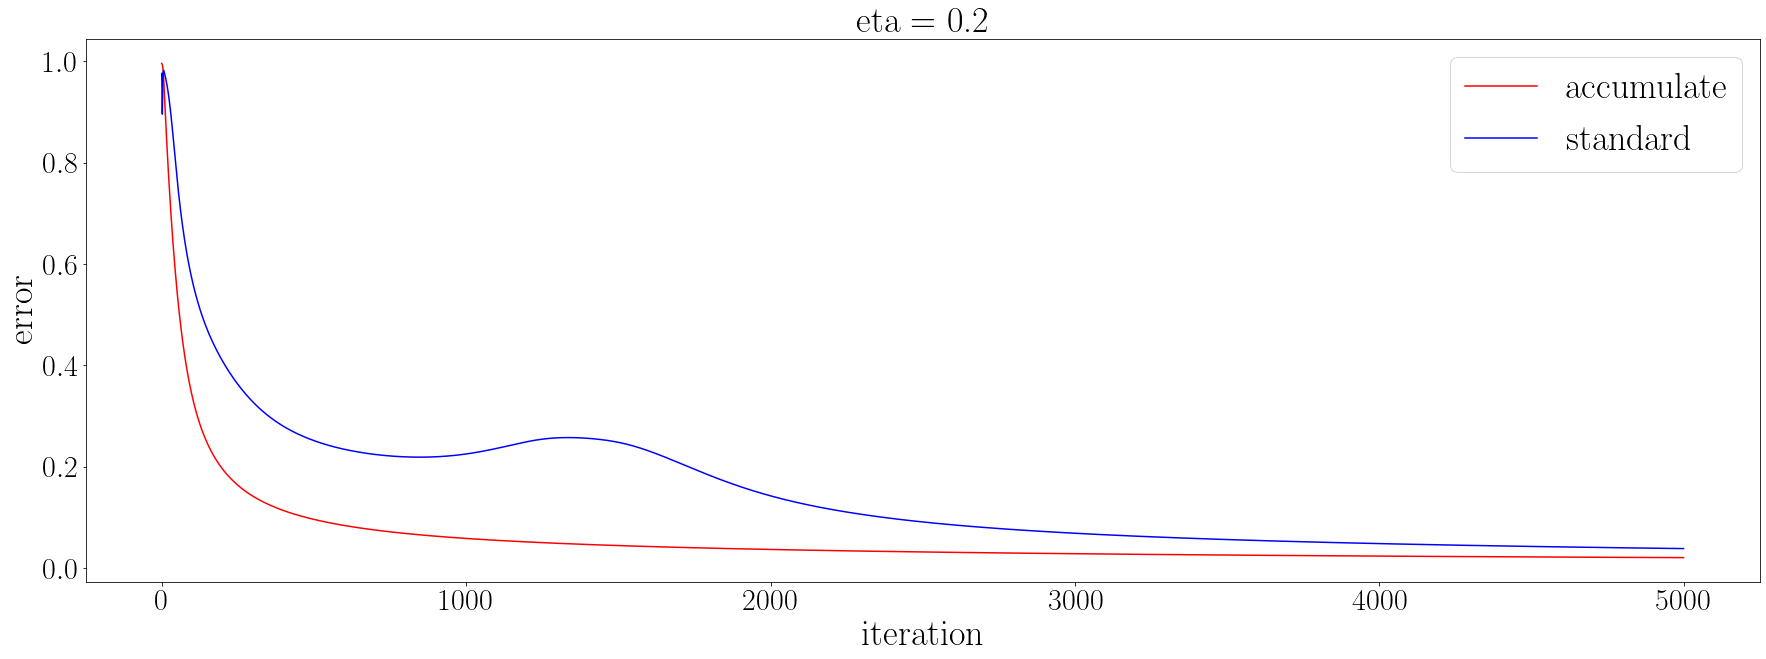

In [55]:
plt.figure(figsize=(30, 10))

# 使用tex渲染
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x = range(maxIter)
plt.plot(x, error_list_accumulate, 'r', label = 'accumulate')
plt.plot(x, error_list_standard, 'b', label = 'standard')
# plt.plot(x, hist['test'], 'g', label = 'test')

plt.tick_params(labelsize=30)
plt.legend(fontsize=36)
plt.xlabel('iteration', fontsize=36)
plt.ylabel('error', fontsize=36)
plt.title("eta = 0.2", fontsize=36)

Model type: accumulate  lr: 0.05  maxIter: 5000
time:  1.586275339126587
Model type: accumulate  lr: 0.2  maxIter: 5000
time:  1.5867581367492676
Model type: accumulate  lr: 0.5  maxIter: 5000
time:  1.5969598293304443


Text(0.5, 1.0, 'accumulate')

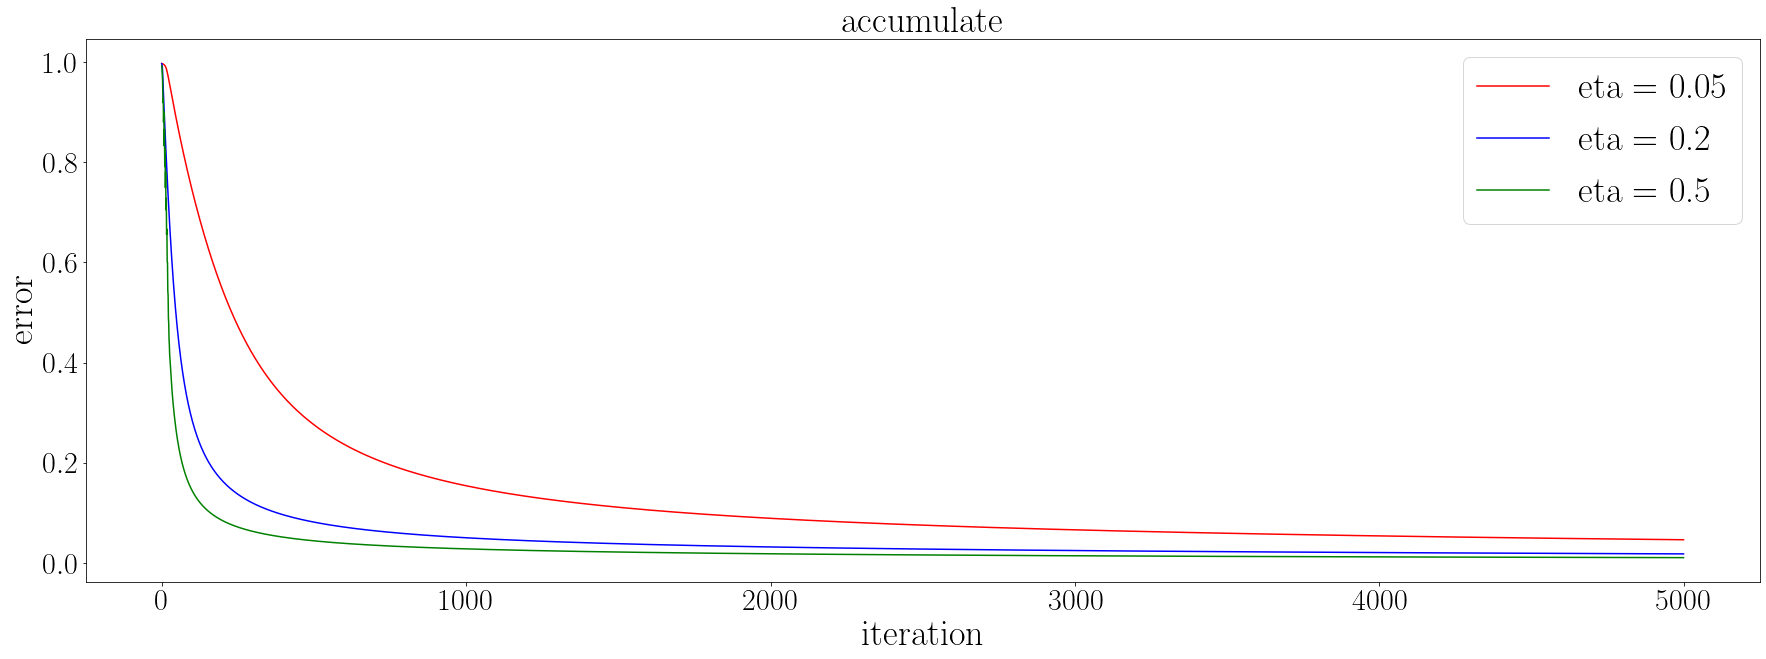

In [45]:
data_dir = './watermelon_3.csv'
eta = 0.05
maxIter = 5000
model_type = 'accumulate'
error_list_lr005 = main()
# model_type = 'standard'
eta = 0.2
error_list_lr02 = main()
eta = 0.5
error_list_lr05 = main()

plt.figure(figsize=(30, 10))

# 使用tex渲染
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x = range(maxIter)
plt.plot(x, error_list_lr005, 'r', label = 'eta = 0.05')
plt.plot(x, error_list_lr02, 'b', label = 'eta = 0.2')
plt.plot(x, error_list_lr05, 'g', label = 'eta = 0.5')

plt.tick_params(labelsize=30)
plt.legend(fontsize=36)
plt.xlabel('iteration', fontsize=36)
plt.ylabel('error', fontsize=36)
plt.title("accumulate", fontsize=36)

Model type: standard  lr: 0.05  maxIter: 5000
time:  5.2821736335754395
Model type: standard  lr: 0.2  maxIter: 5000
time:  5.285930633544922
Model type: standard  lr: 0.5  maxIter: 5000
time:  5.292133092880249


Text(0.5, 1.0, 'standard')

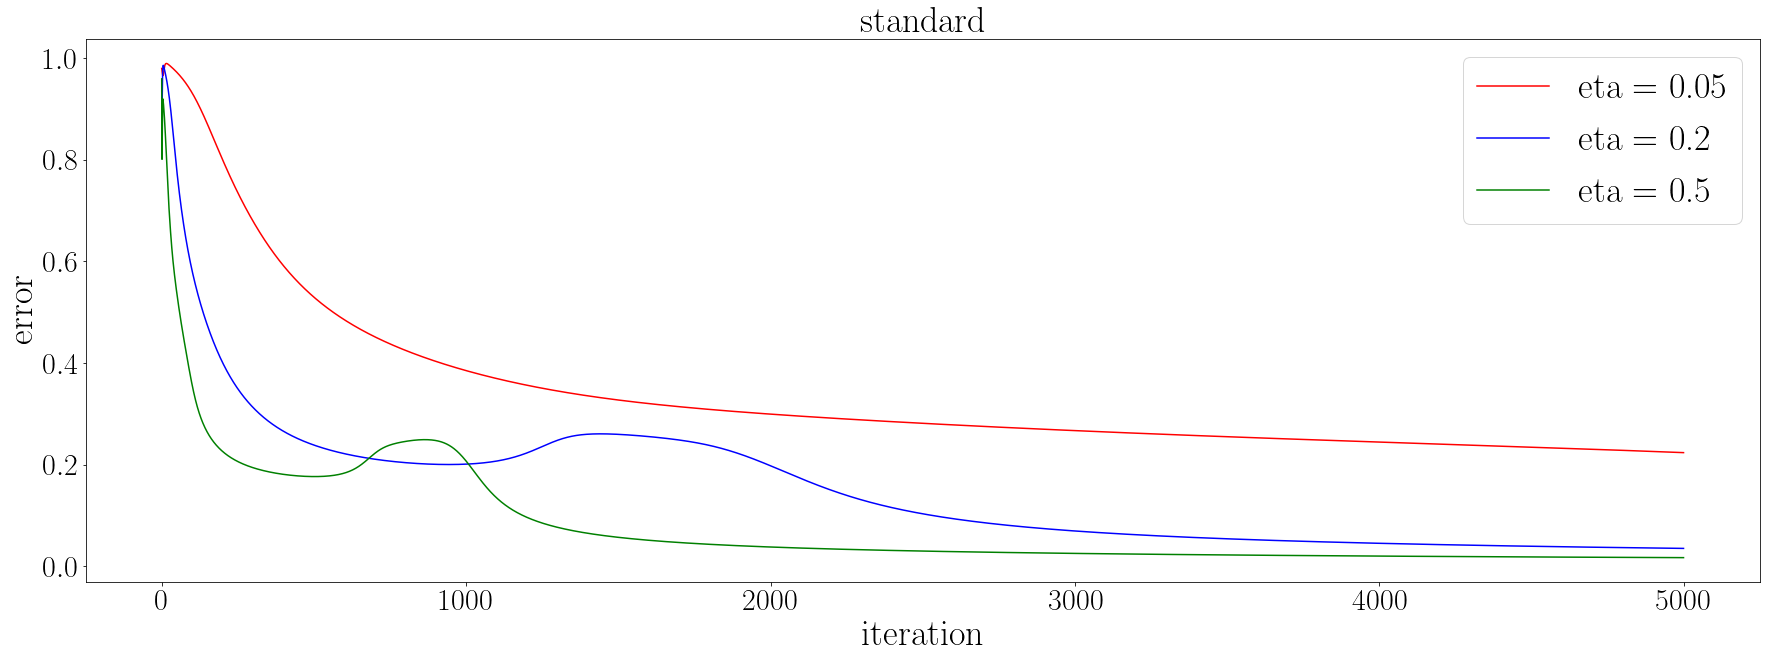

In [43]:
data_dir = './watermelon_3.csv'

maxIter = 5000
model_type = 'standard'
# model_type = 'accumulate'

eta = 0.05
error_list_lr005 = main()
eta = 0.2
error_list_lr02 = main()
eta = 0.5
error_list_lr05 = main()

plt.figure(figsize=(30, 10))

# 使用tex渲染
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x = range(maxIter)
plt.plot(x, error_list_lr005, 'r', label = 'eta = 0.05')
plt.plot(x, error_list_lr02, 'b', label = 'eta = 0.2')
plt.plot(x, error_list_lr05, 'g', label = 'eta = 0.5')

plt.tick_params(labelsize=30)
plt.legend(fontsize=36)
plt.xlabel('iteration', fontsize=36)
plt.ylabel('error', fontsize=36)
plt.title("standard", fontsize=36)